(64, 3, 512, 256)
-0.09626966654538152
0.10462331610707389
(64, 512, 256, 3)


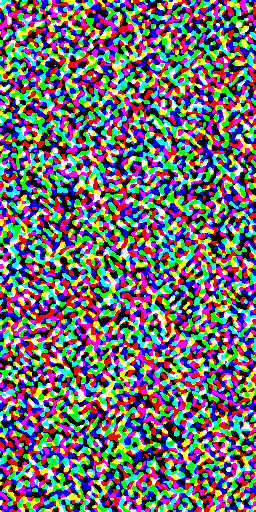

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.fftpack import dct, idct
from PIL import Image

torch.set_printoptions(precision=10)


def get_2d_idct(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')


def RGB_signal_idct(signal):
    assert len(signal.shape) == 3 and signal.shape[0] == 3
    img = np.zeros_like(signal)
    for c in range(3):
        img[c] = get_2d_idct(signal[c])
    return img


inp = np.zeros((3, 512, 256))
C, H, W = inp.shape
factor = 4
h_use, w_use = int(H / factor), int(W / factor)
batch_size = 64

ps = []
for _ in range(batch_size):
    p_signal = np.zeros_like(inp)
    for c in range(C):
        rv = np.random.randn(h_use, w_use)
        rv_ortho, _ = np.linalg.qr(rv, mode='reduced')
        p_signal[c, :h_use, :w_use] = rv_ortho
    p_img = RGB_signal_idct(p_signal)
    ps.append(p_img)
ps = np.stack(ps, axis=0)
print(ps.shape)
print(ps[0].min())
print(ps[0].max())

ps = ps.transpose(0, 2, 3, 1)
print(ps.shape)
Image.fromarray((ps[0] * 255).astype('uint8')).convert('RGBA')

In [2]:
def sample_gaussian_torch(image_size, dct_ratio=0.25):
    noise = torch.zeros(image_size)
    h_use = int(image_size[-2] * dct_ratio)
    w_use = int(image_size[-1] * dct_ratio)
    noise[:, :, :, :h_use, :w_use] = torch.randn(noise.size(0), noise.size(1), noise.size(2), h_use, w_use)
    h_index = len(image_size) - 2
    w_index = len(image_size) - 1
    x = torch.from_numpy(idct(idct(noise.numpy(), axis=w_index, norm='ortho'), axis=h_index, norm='ortho'))
    temp = torch.zeros(image_size)
    return x

In [3]:
def sample_gaussian_torch_qr(image_size, dct_ratio=0.25):
    noise = torch.zeros(image_size)
    h_use = int(image_size[-2] * dct_ratio)
    w_use = int(image_size[-1] * dct_ratio)
    for i in range(noise.shape[0]):
        for j in range(noise.shape[1]):
            for k in range(noise.shape[2]):
                rv = np.random.randn(h_use, w_use)
                rv_ortho, _ = np.linalg.qr(rv, mode='reduced')
                noise[i, j, k, :h_use, :w_use] = torch.tensor(rv_ortho)
    h_index = len(image_size) - 2
    w_index = len(image_size) - 1
    x = torch.from_numpy(idct(idct(noise.numpy(), axis=w_index, norm='ortho'), axis=h_index, norm='ortho'))
    temp = torch.zeros(image_size)
    return x

In [4]:
def sample_gaussian_torch_axis_4(image_size, dct_ratio=0.25):
    noise = torch.zeros(image_size)
    h_use = int(image_size[-2] * dct_ratio)
    w_use = int(image_size[-1] * dct_ratio)
    noise[:, :, :h_use, :w_use] = torch.randn(noise.size(0), noise.size(1), h_use, w_use)
    h_index = len(image_size) - 2
    w_index = len(image_size) - 1
    x = torch.from_numpy(idct(idct(noise.numpy(), axis=w_index, norm='ortho'), axis=h_index, norm='ortho'))
    temp = torch.zeros(image_size)
    return x

In [5]:
def sample_gaussian_torch_qr_axis_4(image_size, dct_ratio=0.25):
    noise = torch.zeros(image_size)
    h_use = int(image_size[-2] * dct_ratio)
    w_use = int(image_size[-1] * dct_ratio)
    print(noise.shape)
    for i in range(noise.shape[0]):
        for j in range(noise.shape[1]):
            rv = np.random.randn(h_use, w_use)
            rv_ortho, _ = np.linalg.qr(rv, mode='reduced')
            noise[i, j, :h_use, :w_use] = torch.tensor(rv_ortho)
    h_index = len(image_size) - 2
    w_index = len(image_size) - 1
    x = torch.from_numpy(idct(idct(noise.numpy(), axis=w_index, norm='ortho'), axis=h_index, norm='ortho'))
    temp = torch.zeros(image_size)
    return x

torch.Size([100, 4, 3, 512, 256])
tensor(-1.1391303539)
tensor(1.1960606575)
Time elapsed: 3.232424259185791


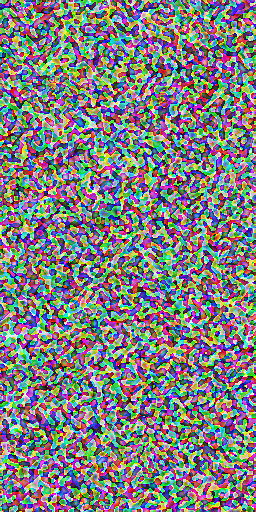

In [6]:
start_time = time.time()

steps = 100
batch_size = 4
x = sample_gaussian_torch([steps, batch_size, 3, 512, 256])
print(x.shape)

print(x[0][0].min())
print(x[0][0].max())
now = x[0][0].permute(1, 2, 0).numpy()

end_time = time.time()
print('Time elapsed:', end_time - start_time)

Image.fromarray((now * 255).astype('uint8')).convert('RGBA')

torch.Size([100, 4, 3, 512, 256])
tensor(-0.1226277500)
tensor(0.1014438868)
Time elapsed: 3.5237176418304443


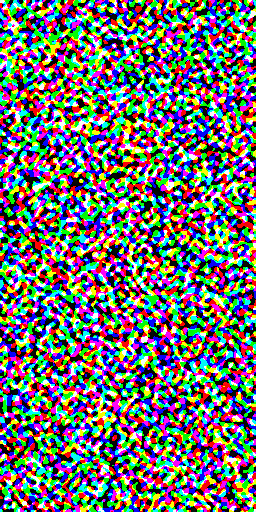

In [7]:
start_time = time.time()

steps = 100
batch_size = 4
x = sample_gaussian_torch_qr([steps, batch_size, 3, 512, 256])
print(x.shape)

print(x[0][0].min())
print(x[0][0].max())
now = x[0][0].permute(1, 2, 0).numpy()

end_time = time.time()
print('Time elapsed:', end_time - start_time)

Image.fromarray((now * 255).astype('uint8')).convert('RGBA')

In [8]:
start_time = time.time()

steps = 100
batch_size = 4
x = sample_gaussian_torch_axis_4([steps, batch_size, 18, 512])
print(x.shape)

print(x[0].min())
print(x[0].max())
now = x[0].permute(1, 2, 0).numpy()

end_time = time.time()
print('Time elapsed:', end_time - start_time)

Image.fromarray((now * 255).astype('uint8')).convert('RGBA')

torch.Size([100, 4, 18, 512])
tensor(-1.2147119045)
tensor(1.0200823545)
Time elapsed: 0.11705923080444336
